## Neural Network model (inflated data)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
# dataset = pd.read_csv('../../dataset-processed/pre-processed-01.csv')
dataset = pd.read_csv('../../dataset-processed/pre-processed-02-brand-paid.csv')
print("Numero di esempi: ", len(dataset))
dataset.head()

Numero di esempi:  11905


,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,52,0,0.000116,0.042888,1,0,0,0,1,0,0
1,0,0,44,0,0.000174,0.057932,1,0,1,0,0,0,0
2,2,4,16,1,0.000044,0.019899,1,0,0,1,0,0,0
3,0,0,1,1,0.000256,0.042174,1,0,1,0,0,0,0
4,0,1,26,0,0.000099,0.042953,1,1,0,0,0,0,0


### Caratteristiche iniziati del dataset

In [3]:
dataset['target'].value_counts()

1    11420
0      485
Name: target, dtype: int64

In [4]:
X = dataset.drop(labels=['target'], axis = 1)
y = dataset['target']

In [5]:
X.head(2)

,hashtag,tag,caption,is_video,n_comment,n_likes,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,52,0,0.000116,0.042888,0,0,0,1,0,0
1,0,0,44,0,0.000174,0.057932,0,1,0,0,0,0


In [6]:
# z-score
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

### Inflate minority class

"By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable. Let’s see if that’s true."

Classi:
- paid = 0
- standard = 1

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
X_train.shape, y_train.shape

((18272, 12), (18272,))

In [10]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', len(X_train) - sum((y_train == 0)))

Esempi training standard:  9136
Esempi training paid:  9136


In [11]:
print('Esempi test standard: ', sum(y_test == 1))
print('Esempi test paid: ', sum(y_test == 0))

Esempi test standard:  2284
Esempi test paid:  97


### Neural network model

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
print(tf.__version__)

2.1.0


In [13]:
def create_model():
    model = Sequential()
    model.add(Dense(X.shape[1], activation="relu", input_dim = X.shape[1]))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
epochs = 20
checkpoint_path = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss', 
    verbose=1,
    save_best_only=False,
    mode='min'
)

model = create_model()
history = model.fit(
    X_train,
    y_train,
    batch_size = 10,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_test, y_test),
    #callbacks=[checkpoint]
)

Train on 18272 samples, validate on 2381 samples
Epoch 1/20
18260/18272 [============================>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.7916 ETA: 4s - loss: 0
Epoch 00001: saving model to model-ep001-loss0.445-val_loss0.427.h5
18272/18272 [==============================] - 5s 255us/sample - loss: 0.4448 - accuracy: 0.7917 - val_loss: 0.4268 - val_accuracy: 0.7766
Epoch 2/20
18120/18272 [============================>.] - ETA: 0s - loss: 0.3490 - accuracy: 0.8501
Epoch 00002: saving model to model-ep002-loss0.349-val_loss0.392.h5
18272/18272 [==============================] - 4s 218us/sample - loss: 0.3488 - accuracy: 0.8501 - val_loss: 0.3920 - val_accuracy: 0.7971
Epoch 3/20
18250/18272 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.8729
Epoch 00003: saving model to model-ep003-loss0.311-val_loss0.323.h5
18272/18272 [==============================] - 4s 227us/sample - loss: 0.3106 - accuracy: 0.8728 - val_loss: 0.3233 - val_accuracy: 0.8404
Epoch 4/20
1

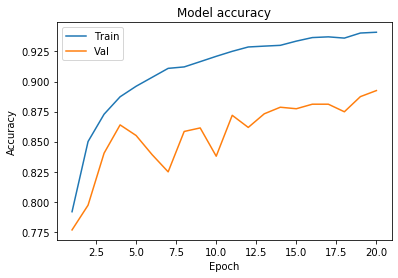

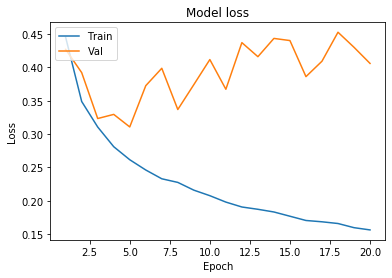

In [15]:
# Plot training & validation accuracy values
epoch_range = range(1, epochs+1)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Evaluate the model

In [16]:
y_pred = model.predict_classes(X_test)
accuracy_score(y_test, y_pred)

0.8924821503569929

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a42ac1a58>)

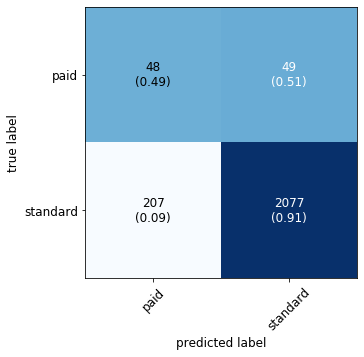

In [17]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.49      0.27        97
           1       0.98      0.91      0.94      2284

    accuracy                           0.89      2381
   macro avg       0.58      0.70      0.61      2381
weighted avg       0.94      0.89      0.91      2381



### Considerazioni sui risultati ottenuti

In [19]:
# df = pd.read_csv('../../dataset/influencer_dataset.csv')
df = pd.read_csv('../../dataset-processed/pre-processed-02-brand-paid.csv')
X = dataset.drop(labels=['target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

##### Valutazione dei F_paid (False Paid)

Predetti come `paid` ma in realta sono `standard`

In [31]:
false_paid = X_test[(y_test == 1) & (y_pred[:,0].T == 0)]
print(len(false_paid))
F_paid_index = false_paid.index.to_list()
F_paid_index[:5]

207


[8134, 3533, 10252, 7715, 9566]

In [56]:
influ = pd.read_csv('../../dataset/influencer_dataset.csv')

##### Verifica siano tutti elementi `standard`

In [58]:
orginal_dataset_FPaid = influ[influ.index.isin(F_paid_index)]
orginal_dataset_FPaid['target'].value_counts()

standard    207
Name: target, dtype: int64

In [59]:
orginal_dataset_FPaid.head(1)

,index,username,photo_id,followed_by,hashtag,tag,caption,is_video,timestamp,n_comment,n_likes,target
52,52,attahalilintar,NaN,11878543,"['#TanpaTapiChallenge', '#UnlimitedTanpaTapi']",['@smartfrenworld.'],Buruan join di TikTok nya aku udah cobain nih ...,True,1582186242,636,101548,standard


In [55]:
influ.loc[8134]

index                                                          9
username                                              paulwalker
photo_id                                             paulwalker9
followed_by                                             11734105
hashtag                                                       []
tag                       ['@pencilsofpromise', '@meadowwalker']
caption        “Today I am launching a campaign with to build...
is_video                                                   False
timestamp                                             1576199357
n_comment                                                    365
n_likes                                                   124552
target                                                  standard
Name: 8134, dtype: object

In [21]:
df.loc[F_paid_index].head()

,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
8134,0,2,45,0,0.000031,0.010615,1,0,0,0,1,0,0
3533,3,1,405,1,0.000250,0.030704,1,1,0,0,0,0,0
10252,0,1,5,0,0.000082,0.004347,1,0,0,0,1,0,0
7715,0,0,11,1,0.000026,0.005993,1,0,0,0,0,0,0
9566,1,1,33,0,0.000735,0.113040,1,0,0,1,0,0,0


##### Valutazione dei T_paid (True Paid)

In [22]:
true_paid = X_test[(y_test == 0) & (y_pred[:,0].T == 0)]
print(len(true_paid))
T_paid_index = true_paid.index.to_list()
T_paid_index[:5]

48


[10935, 1824, 6473, 3427, 2858]

In [23]:
df.loc[T_paid_index].head()

,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
10935,1,1,12,0,0.000012,0.004342,0,0,0,0,0,1,0
1824,3,1,49,0,0.000024,0.008321,0,0,0,1,0,0,0
6473,3,1,33,0,0.000027,0.004920,0,0,0,1,0,0,0
3427,3,1,23,0,0.000118,0.027792,0,0,0,0,0,0,0
2858,1,1,5,0,0.000033,0.023578,0,0,0,1,0,0,0


##### Valutazione dei F_standard (False Standard)

In [24]:
false_standard = X_test[(y_test == 0) & (y_pred[:,0].T == 1)]
print(len(false_standard))
F_standard_index = false_standard.index.to_list()
F_standard_index[:5]

49


[8492, 7406, 653, 3646, 9986]

In [25]:
df.loc[F_standard_index].head()

,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
8492,1,0,19,1,0.000024,0.009362,0,0,0,0,0,0,0
7406,2,2,86,0,0.003996,0.116902,0,0,1,0,0,0,0
653,0,0,15,0,0.000109,0.022363,0,0,0,0,0,0,0
3646,2,2,13,0,0.000506,0.166504,0,0,1,0,0,0,0
9986,5,1,283,0,0.000027,0.010415,0,0,0,0,0,1,0
